# Spaghetti Plots

## Overview
Spaghetti Plots are a tool typically used to visualize movement. Essentially they are many line plots displayed on the same axes. By drawing the same path at different times or from different forecasts, we can see the patterns and chaos associated with the plotted variable.

1. Spaghetti Hurricane Plot
1. Spaghetti Contour Plot


## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necessary | |
| [Cartopy](https://foundations.projectpythia.org/core/cartopy.html) | Necessary | |

- **Time to learn**: 10 minutes

---

In [1]:
import numpy as np
import xarray as xr
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.pylab as pl

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import geocat.viz as gv
import geocat.datafiles as gdf

import tropycal.tracks as tracks

import warnings
warnings.filterwarnings('ignore')

## Spaghetti Hurricane Plot

Visualizing the predicted path of an incoming hurricane is both complicated and important. There are many plots that meteorologists are trained to read, but when shared with the public can be confusing or alarming. There are strengths and weaknesses to each hurricane visualization approach. The cone of uncertainty, for example, is often misinterpreted to suggest the hurricane growth in time rather than widening of path possibilities. Spaghetti plots on the other hand, clearly show hurricane paths but show them as equal to each other.

In this example we will plot some forecasted paths from the 2012 North-Atlantic storm Hurricane Sandy. Each forecast is from the Global Ensemble Forecast System (GEFS) provided by the National Centers for Environmental Prediction at NOAA.

We'll use the package [`tropycal`](tropycal.github.io/tropycal/) to easily access HURDAT2 and IBTrACS reanalysis data and operational National Hurricane Center (NHC) Best Track data. `tropycal` has a lot of great features for real time hurricane visualization, but since this Cookbook is comparatively static we're using a past hurricane and only using this package to access the data. Our plotting will be done with `matplotlib` and `cartopy`.

### Read in Data

First, to grab our hurricane data from tropycal we need to specify a basin:

In [2]:
basin = tracks.TrackDataset(basin='north_atlantic')

--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (1.36 seconds)


Find your storm by name and year:

In [3]:
storm = basin.get_storm(('sandy',2012))

sandy_ds = storm.to_xarray()
sandy_ds

<xarray.Dataset>
Dimensions:    (time: 45)
Coordinates:
  * time       (time) datetime64[ns] 2012-10-21T18:00:00 ... 2012-10-31T12:00:00
Data variables:
    extra_obs  (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 1 1 0 0 0 0 0 0 0
    special    (time) <U1 '' '' '' '' '' '' '' '' ... 'L' '' '' '' '' '' '' ''
    type       (time) <U2 'LO' 'LO' 'LO' 'TD' 'TS' ... 'EX' 'EX' 'EX' 'EX' 'EX'
    lat        (time) float64 14.3 13.9 13.5 13.1 12.7 ... 40.4 40.7 41.1 41.5
    lon        (time) float64 -77.4 -77.8 -78.2 -78.6 ... -79.8 -80.3 -80.7
    vmax       (time) int64 25 25 25 30 35 40 40 40 ... 70 70 55 50 40 35 35 30
    mslp       (time) int64 1006 1005 1003 1002 1000 998 ... 978 986 992 993 995
    wmo_basin  (time) <U14 'north_atlantic' ... 'north_atlantic'
Attributes:
    id:              AL182012
    operational_id:  AL182012
    name:            SANDY
    year:            2012
    season:          2012
    basin:           north_atlantic
    source_info:     NHC Hurricane Database
    source:          hurdat
    ace:             13.6675

And we can grab any of a number of forecasts:

In [4]:
forecasts = storm.get_operational_forecasts()
print(forecasts.keys())

dict_keys(['CARQ', 'CMC', 'NAM', 'NGX', 'UKX', 'AC00', 'AEM2', 'AEMN', 'AP01', 'AP02', 'AP03', 'AP04', 'AP05', 'AP06', 'AP07', 'AP08', 'AP09', 'AP10', 'AP12', 'AP13', 'AP14', 'AP15', 'AP16', 'AP17', 'AP18', 'AP20', 'AVN2', 'AVNO', 'BAMD', 'BAMM', 'BAMS', 'CEMN', 'CLIP', 'CLP5', 'CMC2', 'COT2', 'COTC', 'DSHP', 'FIM9', 'FM92', 'G012', 'GFD2', 'GFDE', 'GFDL', 'GFDT', 'GFT2', 'GHM2', 'GP01', 'GPM2', 'GPMN', 'HWE2', 'HWF2', 'HWFE', 'HWRF', 'ICON', 'IV15', 'IVCN', 'IVCR', 'LBAR', 'LGEM', 'NAM2', 'NGX2', 'OFCP', 'OFP2', 'SHF5', 'SHFR', 'SHIP', 'TCLP', 'TV15', 'TVCA', 'TVCC', 'TVCE', 'TVCN', 'UWN2', 'UWN8', 'XTRP', 'ZGFS', 'AEMI', 'AP11', 'AP19', 'AVNI', 'CMCI', 'COTI', 'FM9I', 'GFDI', 'GFTI', 'GHMI', 'GPMI', 'HWFI', 'NAMI', 'NGXI', 'OFPI', 'RI25', 'SPC3', 'UKXI', 'DRCL', 'GFE2', 'MRCL', 'MRFO', 'UKX2', 'UKM', 'AHW4', 'G01I', 'OFCL', 'OCD5', 'BCD5', 'OCS5', 'BCS5', 'OFCI', 'UKMI', 'AHW2', 'EGRR', 'FSSE', 'RI30', 'RI35', 'RYOC', 'UKM2', 'AHWI', 'EGRI', 'TCOA', 'EGR2', 'UWNI', 'HWEI', 'APSU', 'A

Each key represents a forecast model, we'll select the GFS AP01 forecast which has many initializations. These initializations are named by time in YYYYMMDDHH format:

In [5]:
forecasts_AP01 = forecasts['AP01']
print(forecasts_AP01.keys())

dict_keys(['2012102112', '2012102118', '2012102200', '2012102206', '2012102212', '2012102218', '2012102300', '2012102306', '2012102312', '2012102318', '2012102400', '2012102406', '2012102412', '2012102418', '2012102500', '2012102506', '2012102512', '2012102518', '2012102600', '2012102606', '2012102612', '2012102618', '2012102700', '2012102706', '2012102712', '2012102718', '2012102800', '2012102806', '2012102812', '2012102818', '2012102900', '2012102906', '2012102912', '2012102918', '2012103000', '2012103006', '2012103012', '2012103018', '2012103100'])


### Spaghetti Plot of One Esemble Member

Let's set up our Cartopy grid to plot one ensemble member of the hurricane model.

These steps might be familiar to you but we:
 - create our axes with a Plate Caree projection
 - add land features
 - add grid lines
 - edit our gridline labels to not duplicate on all four sides
 - edit our gridline label fontsize

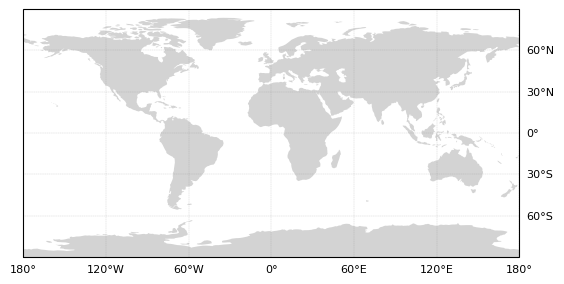

In [6]:
# Set up Cartopy Projection with land features
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Add Gridlines to right and bottom
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.25, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlabel_style = {'size': 8,}
gl.ylabel_style = {'size': 8,}

Looking at GFS Ensemble Member Forecast AP01, we can make a spaghetti plot of each of these initializations.

The crux of the visualization is that we loop through and plot each initialization (in `for i in forecasts_AP01`), plot the true hurricane path, and add a legend (`plt.legend()`).

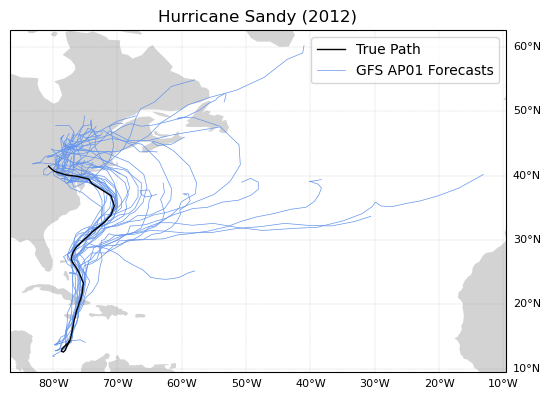

In [7]:
# Set up Cartopy Projection with land features
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Add Gridlines to right and bottom
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.25, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlabel_style = {'size': 8,}
gl.ylabel_style = {'size': 8,}

# Spaghetti Plot of AP01 forecasts
forecasts_AP01 = forecasts['AP01']
for i in forecasts_AP01:
    # We're naming this line even though it is over-written each loop,
    # so that we can reference the last line in the legend
    # (as they all share the same formatting)
    forecast_path = plt.plot(forecasts_AP01[i]['lon'],
                            forecasts_AP01[i]['lat'],
                            color='cornflowerblue',
                            linewidth=0.5)

# Plot the real storm path in a thicker black line
true_path = plt.plot(sandy_ds.lon,
    sandy_ds.lat,
    color='k',
    linewidth=1) # Make it thicker than the ensemble paths

# Add a legend with only one forecast_path and the true_path
plt.legend([true_path[0], forecast_path[0]], ['True Path', 'GFS AP01 Forecasts'])

plt.title('Hurricane Sandy (2012)');

This plot is a great example of a spaghetti plot, but is it super useful? Is it confusing? Each line looks like it carries the same weight, when some of these possible paths are from hours before Sandy hit the American NorthEast and others are from days before.

Maybe it is better to show the user some indication of how the forecast for this ensemble converged on the true path with later and later initialization times.

### Spaghetti Plot of One Esemble Member with Temporal Colormapping

Some additions to look out for:
 - we grab the time information from the initialization name using `datetime`
 - normalize a colormap by the time information with `cmap = mpl.colors.ListedColormap(plt.cm.autumn_r(normalized_times))`
 - loop through the colormap as we loop through the time steps within the ensemble member
 - add a colorbar  with `plt.colorbar(plt.cm.ScalarMappable(cmap=cmap))`, where `ScalarMappable` is used to map scalar data to RGBA.

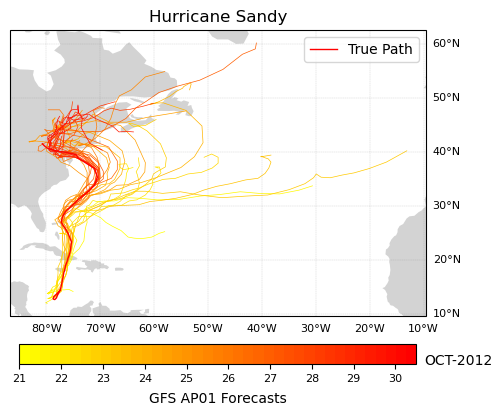

In [8]:
# Set up Cartopy Projection with land features
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Add Gridlines to right and bottom
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.25, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlabel_style = {'size': 8,}
gl.ylabel_style = {'size': 8,}

# Spaghetti Plot of AP01 forecasts
forecasts_AP01 = forecasts['AP01']

# Get time information from initialization name
format = '%Y%m%d%H'
times = [datetime.datetime.strptime(i, format) for i in list(forecasts_AP01.keys())]
normalized_times = [(i - times[0]) / (times[-1] - times[0]) for i in times]

# Create a color list for forecast iteration
cmap = mpl.colors.ListedColormap(plt.cm.autumn_r(normalized_times))

c = 0
for i in forecasts_AP01:
    plt.plot(forecasts_AP01[i]['lon'],
        forecasts_AP01[i]['lat'],
        color=cmap(c),
        linewidth=0.5)
    c += 1

# Plot the real storm path
true_path = plt.plot(sandy_ds.lon,
    sandy_ds.lat,
    color='red', # Selecting a color matching one of the cmap extremes
    linewidth=1,
    label='True Path') # The easiest way to add a plot to the legend is with the label kwarg

# Add a legend with only one the true_path
# Forecasted paths will be shown in a colorbar
plt.legend()

plt.title('Hurricane Sandy')

# Add colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, orientation='horizontal', shrink=0.8, pad=0.075)
cbar.set_label('GFS AP01 Forecasts', labelpad=6)

# Set tick locations and labels for every 4th tick
# i.e. once a day (a new initialiation every 6 hours)
tick_indices = range(0, len(times), 4)
cbar.set_ticks([normalized_times[i] for i in tick_indices])
cbar.set_ticklabels([times[i].strftime('%d') for i in tick_indices], fontsize=8)
cbar.ax.text(1.02, 0.5, 'OCT-2012', va='top', ha='left', transform=cbar.ax.transAxes);

Now we can see that as the storm progressed, the AP01 GFS Forecast Ensemble Member converges on Sandy's true path as the storm progresses through October, 2012.

Alternatively, we may want to plot the possible hurricane paths from multiple GFS Forecast Ensemble members from the same iteration timestamp as a spaghetti plot.

### Spaghetti Plot of All Esemble Members at One Point in Time

First, we need to grab all of the relevant forecast keys to GFS models (the ones that are titled `AP##` from 0 to 20):

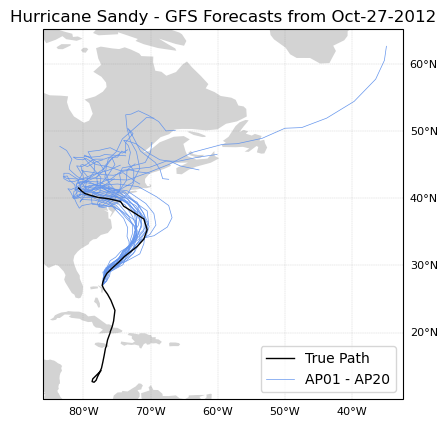

In [9]:
# List of valid AP## keys from 0 to 20
GFS_keys = ['AP' + str(i).zfill(2) for i in range(1, 21)]

# Arbitrarily selected midnight on October 27, 2012 to plot all forecasts at
time = '2012102700'

# Set up Cartopy Projection with land features
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Add Gridlines to right and bottom
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.25, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlabel_style = {'size': 8,}
gl.ylabel_style = {'size': 8,}

# Spaghetti Plot of forecasts
for i in range(20):
    ap = forecasts[GFS_keys[i]]
    forecast_path = plt.plot(ap[time]['lon'],
        ap[time]['lat'],
        color='cornflowerblue',
        linewidth=0.5)

# Plot the real storm path in a thicker black line
true_path = plt.plot(sandy_ds.lon, sandy_ds.lat, color='k', linewidth=1)

# Add a legend with only one forecast_path and the true_path
plt.legend([true_path[0], forecast_path[0]],
    ['True Path', 'AP01 - AP20'],
    loc='lower right')

plt.title('Hurricane Sandy - GFS Forecasts from Oct-27-2012');

Hurricane Sandy hit the NorthEast on October 29, 2012. From this spaghetti plot we can see that by the 27th most ensemble members of the GFS forecast predicted a similar behavior for the storm.

There is more analysis that could be done on hurriane trajectories. We have covered some plotting customization that might be useful for your analysis and data visualization.

## Spaghetti Contour Plot

In this example we will read in the geopotential height datafile `HGT500_MON_1958-1997.nc` from using geocat-datafiles. Then we will look at different timesteps of the `HGT` geopotential height variable at the 5500 gpm level, plotting this contour's locations through time. This example is adapted from [GeoCAT](https://geocat.ucar.edu/)'s [NCL_conOncon_5](https://geocat-examples.readthedocs.io/en/latest/gallery/Contours/NCL_conOncon_5.html) script.

### Read in data:



In [10]:
ds = xr.open_dataset(gdf.get("netcdf_files/HGT500_MON_1958-1997.nc"),
                     decode_times=False)

ds

<xarray.Dataset>
Dimensions:  (time: 480, lat: 73, lon: 144)
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 476.0 477.0 478.0 479.0
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    yrmon    (time) float64 ...
    HGT      (time, lat, lon) float32 ...
Attributes:
    conventions:    None
    history:        NCEP/NCAR REANALYSIS MONTHLY MEAN SUBSETS\nftp://ncardata...
    source:         NCEP Reanalysis; ds090.2
    title:          500mb Geopotential Height: 1958-1997
    source_mss:     /SHEA/HVL/HGT_1958-1997.nc:  500 mb extracted
    creation_date:  creation date: Tue Aug  7 16:31:48 MDT 2001

### Initial Spaghetti Plot on North Polar Stereographic Projection

Again, first let's set up our Cartopy axes. This time setting our projection to `NorthPolarStereo`.

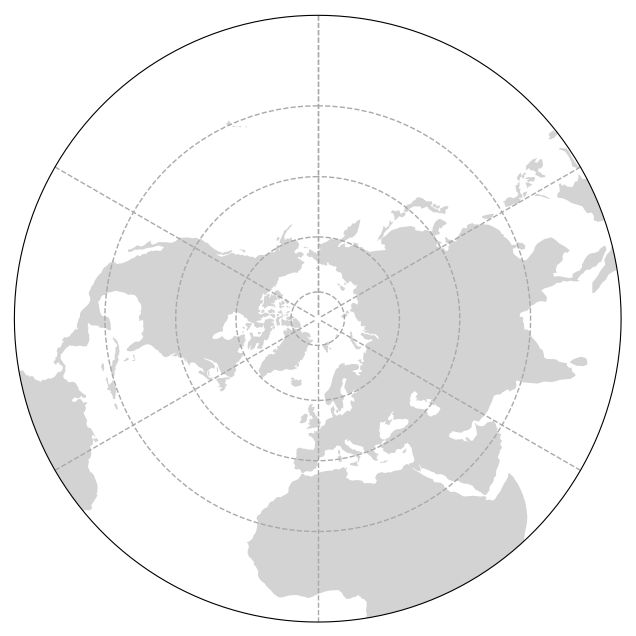

In [15]:
# Set up Cartopy Map Projection
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

gv.set_map_boundary(ax, [-180, 180], [0, 40], south_pad=1)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Set draw_labels to False so that we can manually manipulate it
gl = ax.gridlines(ccrs.PlateCarree(),
                  draw_labels=False,
                  linestyle="--",
                  linewidth=1,
                  color='darkgray',
                  zorder=2)

Then let's add our data to this plot.

We will iterate through every 12th timestep
 - handling any artifacts of the global wrapping at 0 or 360 degrees with `gv.xr_add_cyclic_longitudes(p, "lon")`
 - and calling a contour plot on a single level.

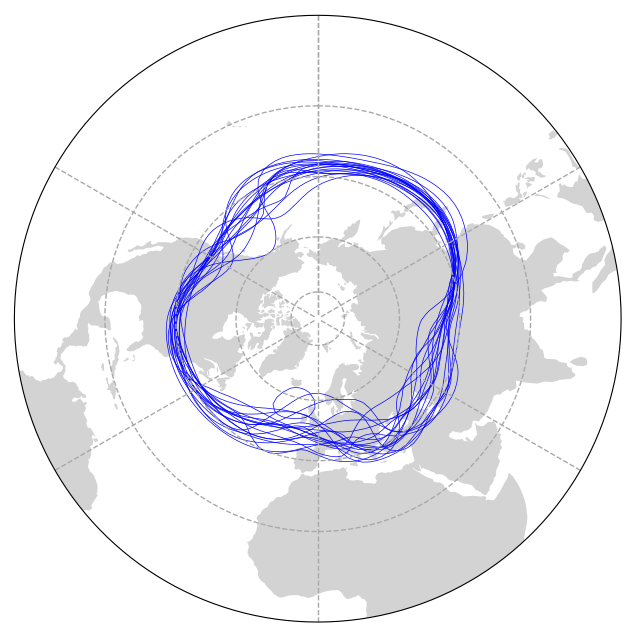

In [11]:
# Set up Cartopy Map Projection
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

gv.set_map_boundary(ax, [-180, 180], [0, 40], south_pad=1)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Set draw_labels to False so that we can manually manipulate it
gl = ax.gridlines(ccrs.PlateCarree(),
                  draw_labels=False,
                  linestyle="--",
                  linewidth=1,
                  color='darkgray',
                  zorder=2)

# Iterate through the 19 timesteps, plotting the data
n = 19
for x in range(n):

    # Get a slice of data at the 12*x timestep
    p = ds.HGT.isel(time=12*x)

    # Use geocat-viz utility function to handle the no-shown-data artifact
    # of 0 and 360-degree longitudes
    slon = gv.xr_add_cyclic_longitudes(p, "lon")

    # Plot contour data at pressure level 5500 for the 12*x timestep
    p = slon.plot.contour(ax=ax,
                          transform=ccrs.PlateCarree(),
                          linewidths=0.5,
                          levels=[5500],
                          colors='blue',
                          add_labels=False)

### Adding Directional Labels to Polar Stereographic Projection

Adding labels to a map projection that aren't lat/lon coordinates is less than intuitive. In this example we manually add labels and select their locations so that you can see NESW labels.

For this we use `mticker.FixedLocator()` to manipulare gridline spacing, manipulate East and West tick labels separately, and specify tick locations with `ax.text(transform=ccrs.Geodetic())`.

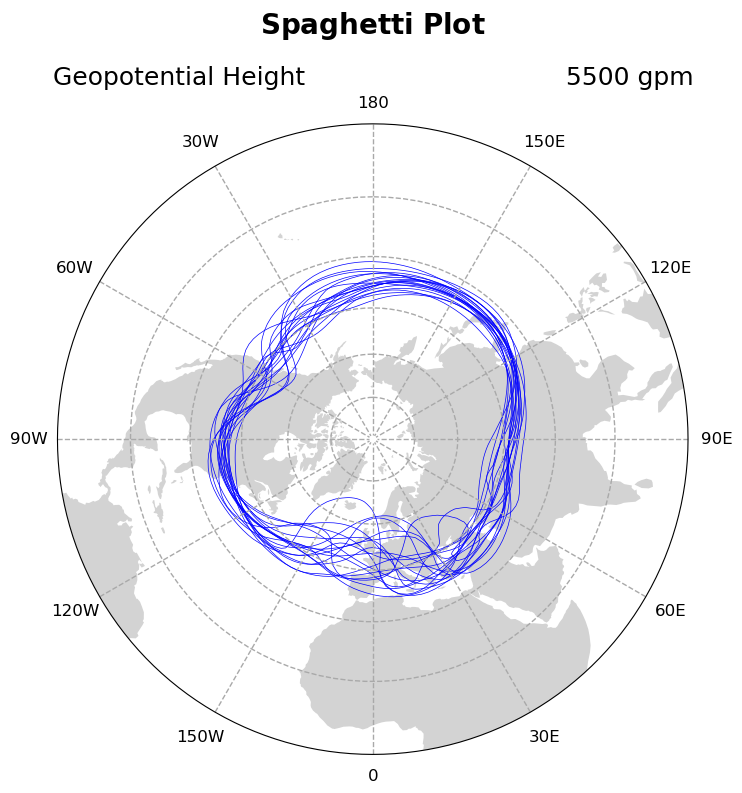

In [12]:
# Generate a figure
fig = plt.figure(figsize=(8, 8))

# Create an axis with a polar stereographic projection
ax = plt.axes(projection=ccrs.NorthPolarStereo())

# Add land feature to map
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Set map boundary to include latitudes between 0 and 40 and longitudes
# between -180 and 180 only
gv.set_map_boundary(ax, [-180, 180], [0, 40], south_pad=1)

# Set draw_labels to False so that you can manually manipulate it later
gl = ax.gridlines(ccrs.PlateCarree(),
                  draw_labels=False,
                  linestyle="--",
                  linewidth=1,
                  color='darkgray',
                  zorder=2)

# Manipulate latitude and longitude gridline numbers and spacing
gl.ylocator = mticker.FixedLocator(np.arange(0, 90, 15))
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))

# Manipulate longitude labels (0, 30 E, 60 E, ..., 30 W, etc.)
ticks = np.arange(0, 210, 30)
etick = ['0'] + [
    r'%dE' % tick for tick in ticks if (tick != 0) & (tick != 180)
] + ['180']
wtick = [r'%dW' % tick for tick in ticks if (tick != 0) & (tick != 180)]
labels = etick + wtick
xticks = np.arange(0, 360, 30)
yticks = np.full_like(xticks, -5)  # Latitude where the labels will be drawn
for xtick, ytick, label in zip(xticks, yticks, labels):
    if label == '180':
        ax.text(xtick,
                ytick,
                label,
                fontsize=12,
                horizontalalignment='center',
                verticalalignment='top',
                transform=ccrs.Geodetic())
    elif label == '0':
        ax.text(xtick,
                ytick,
                label,
                fontsize=12,
                horizontalalignment='center',
                verticalalignment='bottom',
                transform=ccrs.Geodetic())
    else:
        ax.text(xtick,
                ytick,
                label,
                fontsize=12,
                horizontalalignment='center',
                verticalalignment='center',
                transform=ccrs.Geodetic())

# Iterate through 18 different timesteps
for x in range(19):

    # Get a slice of data at the 12*x+1 timestep
    p = ds.HGT.isel(time=12 * x + 1)

    # Use geocat-viz utility function to handle the no-shown-data artifact
    # of 0 and 360-degree longitudes
    slon = gv.xr_add_cyclic_longitudes(p, "lon")

    # Plot contour data at pressure level 5500 for the 12*x+1 timestep
    p = slon.plot.contour(ax=ax,
                          transform=ccrs.PlateCarree(),
                          linewidths=0.5,
                          levels=[5500],
                          colors='blue',
                          add_labels=False)

# Use geocat.viz.util convenience function to add titles
gv.set_titles_and_labels(ax,
                         maintitle=r"$\bf{Spaghetti}$" + " " + r"$\bf{Plot}$",
                         lefttitle=slon.long_name,
                         righttitle='5500 '+slon.units)

# Make tight layout
plt.tight_layout()

Now in this example, there isn't necessarily a temporal progression of geopotential height, but to be sure let's add a colormap component to each of our loops. 

This is also useful because for your data visualization application there might be, and the commands are slightly different for a contour plot as for a line plot in the above example.

### Contour Spaghetti Plot Temporal Colorbar Manipulation

Let's update add a discrete colorbar that has yearly ticklabels. One challenge addressed in this example is setting the ticklabels to be in the center of each discrete color box.

New code lines here are:
 - creating a discrete colormap with `plt.get_cmap('winter_r', n)` and color bounds with `np.linspace()`
 - specifying the color in each contour call with `colors=[cmap(bounds)[x]]`
 - adjusting the time unit for the colorbar ticks
 - adding a colorbar for the normalized colormap, calling the `orientation`, `shrink`, and `pad` keyword arguments to make it display well
 - setting colorbar tick location to be at color midpoints with `cbar.set_ticks()`, yet forcing their labels to be years (not year midpoints) with `cbar.set_ticklabels()`

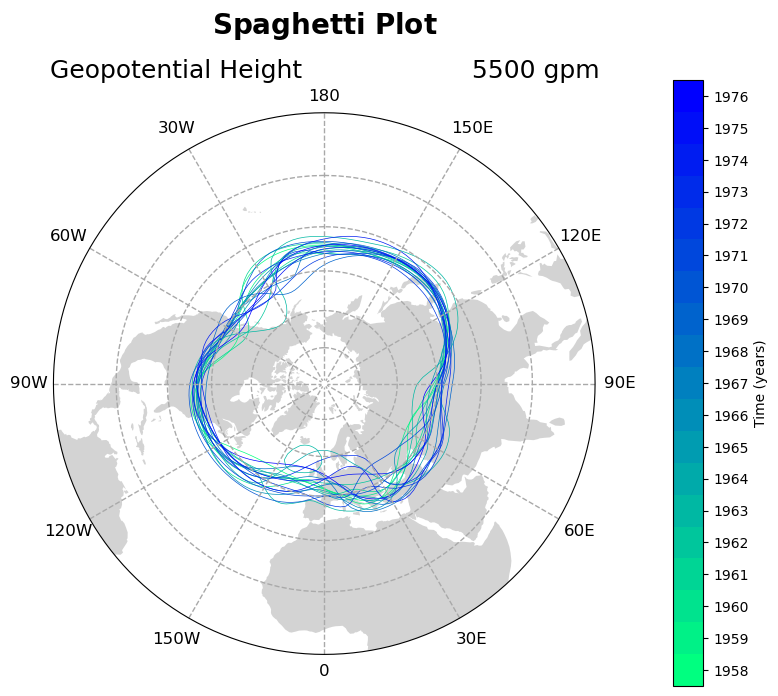

In [13]:
# Set up Cartopy Map Projection
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

gv.set_map_boundary(ax, [-180, 180], [0, 40], south_pad=1)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Set draw_labels to False so that we can manually manipulate it
gl = ax.gridlines(ccrs.PlateCarree(),
                  draw_labels=False,
                  linestyle="--",
                  linewidth=1,
                  color='darkgray',
                  zorder=2)

# Manipulate latitude and longitude gridline numbers and spacing
gl.ylocator = mticker.FixedLocator(np.arange(0, 90, 15))
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))

# Manipulate longitude labels (0, 30 E, 60 E, ..., 30 W, etc.)
ticks = np.arange(0, 210, 30)
etick = ['0'] + [
    r'%dE' % tick for tick in ticks if (tick != 0) & (tick != 180)
] + ['180']
wtick = [r'%dW' % tick for tick in ticks if (tick != 0) & (tick != 180)]
labels = etick + wtick
xticks = np.arange(0, 360, 30)
yticks = np.full_like(xticks, -5)  # Latitude where the labels will be drawn
for xtick, ytick, label in zip(xticks, yticks, labels):
    if label == '180':
        ax.text(xtick,
                ytick,
                label,
                fontsize=12,
                horizontalalignment='center',
                verticalalignment='top',
                transform=ccrs.Geodetic())
    elif label == '0':
        ax.text(xtick,
                ytick,
                label,
                fontsize=12,
                horizontalalignment='center',
                verticalalignment='bottom',
                transform=ccrs.Geodetic())
    else:
        ax.text(xtick,
                ytick,
                label,
                fontsize=12,
                horizontalalignment='center',
                verticalalignment='center',
                transform=ccrs.Geodetic())

# Create a color list for each of the 19 contours
n = 19
cmap = plt.get_cmap('winter_r', n) # the `, n` makes the colormap display discretized
bounds = np.linspace(0, 1, n)

# Iterate through the timesteps
for x in range(n):

    # Get a slice of data at the 12*x timestep
    p = ds.HGT.isel(time=12*x)

    # Handle wrapping artifacts
    slon = gv.xr_add_cyclic_longitudes(p, "lon")

    # Plot contour data at pressure level 5500 for the 12*x timestep
    p = slon.plot.contour(ax=ax,
                          transform=ccrs.PlateCarree(),
                          linewidths=0.5,
                          levels=[5500],
                          colors=[cmap(bounds)[x]], # set colors to use our new cmap
                          add_labels=False)

# Add a colorbar
# The default time unit is in months since 1958, years is more intuitive
year_0 = 1958
year_n = (ds.time.isel(time=12*n) / 12).astype(int) + year_0

norm = plt.Normalize(vmin=year_0, vmax=year_n)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ax=ax,
    orientation='vertical',
    shrink=0.8, # Shrink to the approximate size of the map
    pad = 0.1) # Pad so colorbar doesn't overlap with directional label

cbar.set_ticks(np.arange(year_0+0.5, year_n)) # Set tick locations to be at color midpoints
cbar.set_ticklabels(np.arange(year_0, year_n)) # Set tick labels to be years (despite their location value being year + 0.5)
cbar.set_label('Time (years)')

# Use geocat.viz.util convenience function to add titles
gv.set_titles_and_labels(ax,
                         maintitle=r"$\bf{Spaghetti}$" + " " + r"$\bf{Plot}$",
                         lefttitle=slon.long_name,
                         righttitle='5500 '+slon.units)

# Make tight layout
plt.tight_layout();

### Contour Spaghetti Plot with Hand-Picked Colors

If you want your plot to be visually appealing it might be worth selecting different colors for each contour plot in the for-loop, however these do not have to be sequentially ordered or time-aware. It is actually simplest to hand-pick colors for each loop. In this iteration of the plot we hand pick colors in a `colorlist` and plot the first time step on its own to demonstrate plotting one loop unlike the others.

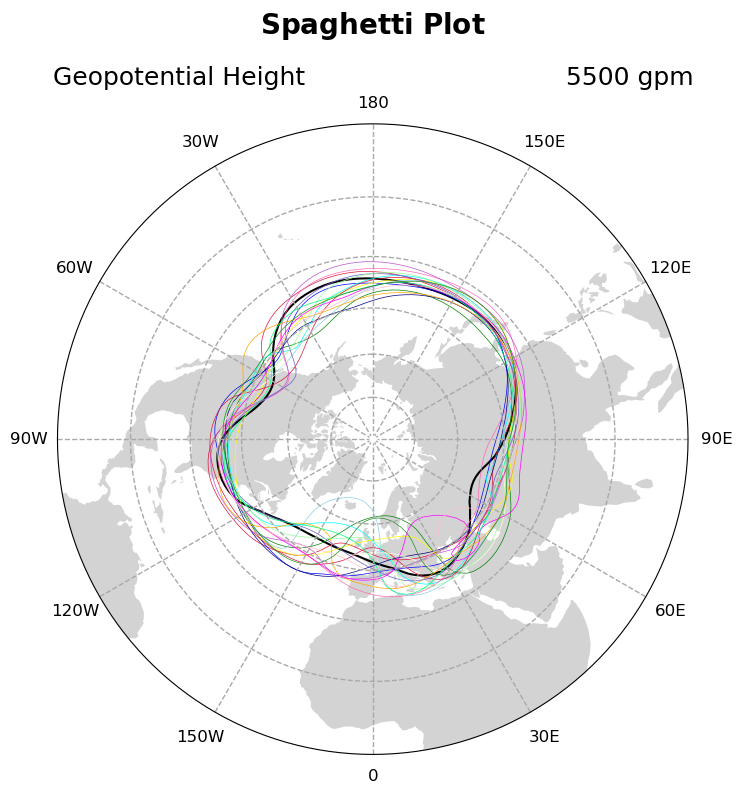

In [14]:
# Generate a figure
fig = plt.figure(figsize=(8, 8))

# Create an axis with a polar stereographic projection
ax = plt.axes(projection=ccrs.NorthPolarStereo())

# Add land feature to map
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Set map boundary to include latitudes between 0 and 40 and longitudes
# between -180 and 180 only
gv.set_map_boundary(ax, [-180, 180], [0, 40], south_pad=1)

# Set draw_labels to False so that you can manually manipulate it later
gl = ax.gridlines(ccrs.PlateCarree(),
                  draw_labels=False,
                  linestyle="--",
                  linewidth=1,
                  color='darkgray',
                  zorder=2)

# Manipulate latitude and longitude gridline numbers and spacing
gl.ylocator = mticker.FixedLocator(np.arange(0, 90, 15))
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))

# Manipulate longitude labels (0, 30 E, 60 E, ..., 30 W, etc.)
ticks = np.arange(0, 210, 30)
etick = ['0'] + [
    r'%dE' % tick for tick in ticks if (tick != 0) & (tick != 180)
] + ['180']
wtick = [r'%dW' % tick for tick in ticks if (tick != 0) & (tick != 180)]
labels = etick + wtick
xticks = np.arange(0, 360, 30)
yticks = np.full_like(xticks, -5)  # Latitude where the labels will be drawn
for xtick, ytick, label in zip(xticks, yticks, labels):
    if label == '180':
        ax.text(xtick,
                ytick,
                label,
                fontsize=12,
                horizontalalignment='center',
                verticalalignment='top',
                transform=ccrs.Geodetic())
    elif label == '0':
        ax.text(xtick,
                ytick,
                label,
                fontsize=12,
                horizontalalignment='center',
                verticalalignment='bottom',
                transform=ccrs.Geodetic())
    else:
        ax.text(xtick,
                ytick,
                label,
                fontsize=12,
                horizontalalignment='center',
                verticalalignment='center',
                transform=ccrs.Geodetic())

# Get slice of data at the 0th timestep - plot this contour line separately
# because it will be thicker than the other contour lines
p = ds.HGT.isel(time=0)

# Use geocat-viz utility function to handle the no-shown-data
# artifact of 0 and 360-degree longitudes
slon = gv.xr_add_cyclic_longitudes(p, "lon")

# Plot contour data at pressure level 5500 at the first timestep
p = slon.plot.contour(ax=ax,
                      transform=ccrs.PlateCarree(),
                      linewidths=1.5,
                      levels=[5500],
                      colors='black',
                      add_labels=False)

# Create a color list for each of the next 18 contours
colorlist = [
    "crimson", "green", "blue", "yellow", "cyan", "hotpink", "crimson",
    "skyblue", "navy", "lightyellow", "mediumorchid", "orange", "slateblue",
    "palegreen", "magenta", "springgreen", "pink", "forestgreen", "violet"
]

# Iterate through 18 different timesteps
for x in range(18):

    # Get a slice of data at the 12*x+1 timestep
    p = ds.HGT.isel(time=12 * x + 1)

    # Use geocat-viz utility function to handle the no-shown-data artifact
    # of 0 and 360-degree longitudes
    slon = gv.xr_add_cyclic_longitudes(p, "lon")

    # Plot contour data at pressure level 5500 for the 12*x+1 timestep
    p = slon.plot.contour(ax=ax,
                          transform=ccrs.PlateCarree(),
                          linewidths=0.5,
                          levels=[5500],
                          colors=colorlist[x],
                          add_labels=False)

# Use geocat.viz.util convenience function to add titles
gv.set_titles_and_labels(ax,
                         maintitle=r"$\bf{Spaghetti}$" + " " + r"$\bf{Plot}$",
                         lefttitle=slon.long_name,
                         righttitle='5500 '+slon.units)

# Make tight layout
plt.tight_layout()

---

## Summary

Spaghetti Plots are many lines drawn on the same figure. They have pros and cons. They are visually stunning but can be confusing, so it is important to make sure your data visualization conveys accurate information either by manipulating color or linewidth. Since the manipulation of spaghetti plots have their own considerations, this chapter shows several design choices that you can use to jumpstart your visualization needs.


### What's next?

Next up let's discuss [Animation](animation).

## Resources and references

- [Tropycal documentation](https://tropycal.github.io/tropycal/)
- [GeoCat-examples Visualization Gallery](https://geocat-examples.readthedocs.io/en/latest/)
- [GeoCAT-Viz documentation](https://geocat-viz.readthedocs.io/en/latest/)
